In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/berkeley-segmentation-dataset-500-bsds500")

print("Path to dataset files:", path)

C:\Users\Nosse\anaconda3\envs\TED\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 56.0M/56.0M [00:10<00:00, 5.83MB/s]

Extracting files...


Path to dataset files: C:\Users\Nosse\.cache\kagglehub\datasets\balraj98\berkeley-segmentation-dataset-500-bsds500\versions\1


In [38]:
import os
import cv2
import torch
import numpy as np
import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

class BSDS500TrainDataset(Dataset):
    def __init__(self, images_dir, gt_dir, img_size=(320,320)):
        self.images_dir = images_dir
        self.gt_dir = gt_dir
        self.images = sorted(os.listdir(images_dir))
        self.img_size = img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        gt_name = img_name.replace(".jpg", ".mat")
        gt_path = os.path.join(self.gt_dir, gt_name)

        # Leggi immagine
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2,0,1)  # C,H,W

        # Leggi ground truth
        mat = sio.loadmat(gt_path)
        edges_list = mat['groundTruth'][0]
        edge_maps = []

        for e in edges_list:
            if 'Boundaries' in e[0][0].dtype.names:
                b = e[0][0]['Boundaries'][0][0]
                if b.size > 0:  # solo se non vuoto
                    edge_maps.append(b)
        
        if len(edge_maps) == 0:
            # fallback: se non ci sono Boundaries, crea array di zeri
            edge_map = np.zeros((320,320), dtype=np.float32)
        else:
            edge_map = np.max(edge_maps, axis=0)  # combinazione delle annotazioni
            edge_map = np.array(edge_map, dtype=np.float32)
            edge_map = cv2.resize(edge_map, (320,320), interpolation=cv2.INTER_NEAREST)

        return img, edge_map

# ----------------------------
# Esempio di utilizzo
images_dir = r"C:\Users\Nosse\.cache\kagglehub\datasets\balraj98\berkeley-segmentation-dataset-500-bsds500\versions\1\images\train"
gt_dir = r"C:\Users\Nosse\.cache\kagglehub\datasets\balraj98\berkeley-segmentation-dataset-500-bsds500\versions\1\ground_truth\train"

train_dataset = BSDS500TrainDataset(images_dir, gt_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# controlla il numero di immagini
print("Numero immagini train:", len(train_dataset))

# controlla il primo sample
img, gt = train_dataset[0]
print("Shape immagine:", img.shape)
print("Shape ground truth:", gt.shape)





Numero immagini train: 201
Shape immagine: torch.Size([3, 320, 320])
Shape ground truth: (320, 320)


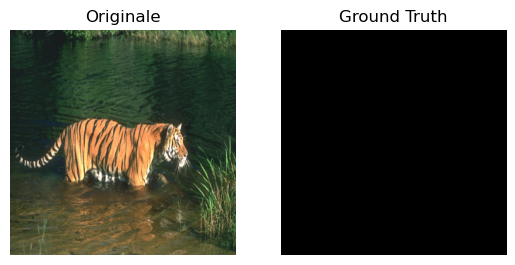

In [43]:
import matplotlib.pyplot as plt

img, gt = train_dataset[10]
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Originale")
plt.axis("off")

plt.subplot(1,2,2)
if gt.ndim == 3:
    plt.imshow(gt[0], cmap="gray")
else:
    plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.show()

In [44]:

#import sys
#sys.path.append(r"C:\Users\Nosse\\TEED-main")  # cartella dove c'è model.py

#from ted import TED


#device = "cuda" if torch.cuda.is_available() else "cpu"

#ted = TED().to(device)
#checkpoint = torch.load("pretrained/teed.pth", map_location=device)
#ted.load_state_dict(checkpoint)
#ted.eval()